# Unsupervised Clustering

Basic implementation of t-SNE algorithm, where first also PCA is applied to reduce simentionality <br>
Reference: https://github.com/sinanatra/image-tsne/blob/master/tsne.ipynb <br>

### Table of Contents

* [1 Theory](#chapter1)
    * [1.1 PCA](#section_1_1)
    * [1.2 t-SNE](#section_1_2)
* [2 Code](#chapter2)
    * [2.0 Imports](#section_2_0)
    * [2.1 Load and normalise data](#section_2_2)
    * [2.2 Reduce the dimensionality](#section_2_3)
    * [2.3 t-SNE](#section_2_4)
    * [2.4 Data visualisation](#section_2_5)

## 1. Theory <a class="anchor" id="chapter1"></a>

### 1.1 PCA <a class="anchor" id="section_1_1"></a>

Provided a dataset consituted by a sequence of $n$ vectors, each one of dimension $m$, the Principal Component Analysis (PCA) is a technique used to select the dimension that are more important in the analysis, so that not all of them need to be used. 

More precisely, we call $\vec{x}_i \in \mathbb{R}^{m}$ the vector referring to the $i-$th element of the dataset, and we call $X \in M_{nxm}$ the matrix that has as rows the data vectors and as columns all the data referring to the same feature. We assume that the dataset has been normalised. 

We are then interested in finding the axis of the multi-dimensional space of the dataset where the information is more spread out. More specifically, we want to find a new basis of the space $\mathbb{R}^{nxm}$, a basis where the variance of of the data is the most spread out, and only select the first $N$ dimensions. In this way we reduce the dimension of the problem but we make sure that the selected dimensions are the ones where the information is the most significant. 

We want to find a vector $\vec{w}$ which maximises the variance $\sigma^2_{\vec{w}}$.

$$
    \sigma^2_{\vec{w}} = \frac{1}{n} \sum\limits_{i = 1} ^ n \left( \vec{x}_i \cdot \vec{w} \right)^2 = \frac{1}{n} (X \vec{w})^{T} (X \vec{w}) = \vec{w}^T \frac{X^T X}{n} \vec{w} = \vec{w}^T \text{Cov}(X,X) \vec{w} = \vec{w}^T A \vec{w}
$$

We now want to maximize thism with the condition that $\| \vec{w} \| = 1$, since it must only tell us the direction. This means that we want to maximize $\vec{w}^T A \vec{w}$ with the condition $\vec{w}^T \vec{w} = 1$. This is a constrained optimization: the function $f(\vec{w}) = \vec{w}^T A \vec{w}$ needs to be opmized on the sub-manifold induced by the constraining functiion $g(\vec{w}) = \vec{w}^T \vec{w} - 1$.
We then take the two gradients and set one proportional to the other (also known as Lagrangan multipliers). 

$$
    \nabla_{\vec{w}} f(x) = \alpha \nabla_{\vec{w}} g(x) \;\;\;\; \to \;\;\;\; 2A\vec{w} = 2\alpha \vec{w} \;\;\;\; \to \;\;\;\; A\vec{w} = \alpha \vec{w}
$$

In such a way we discover that the vectors leading to the basis with a higher variance of the data are the eigenvectors of the covariance matrix $A = \text{Cov}(X,X)$.

Doing a PCA means then diagonalising the Covariance matrix of the data and selecting the directions with the highest eigenvalue. 

### 1.2 t-SNE <a class="anchor" id="section_1_2"></a>

t-SNE stands for t-distributed stochastic neighbor embedding. This is an algorithm used to project higher dimensional data in a subspace, usually 2 or 3 dimensional, where the points are already clustered by similarity and distributed according to a t-Student function. 

The algorithm works in the following way. Once again our $\vec{x}_i \in \mathbb{R}^m$ represents one point of the dataset. We then define the probability that the point $j$ belongs to the cluster centered on $i$ as 

$$
    p_{j|i} = \frac{
                \exp(- \| \vec{x}_i - \vec{x}_j \|^2 / 2\sigma^2_i)
                    }{
                    \sum\limits_{k \neq i} \exp(- \| \vec{x}_i - \vec{x}_k \|^2 / 2\sigma^2_i)
                    }
$$

Simmetrically we define $p_{i|j}$ and then the more general probability that $i$ and $j$ belong to the same cluster as $p_{ij} = (p_{j|i} + p_{i|j}) / 2$

Which gives the probability that $j$ belongs to the cluster centered on $i$ supposing that the probability is gaussian and depending on the Euclidean distance. 

We want out algorithm to learn a set of $\{ y_i \in \mathbb{R}^h, i = 1, \dots, n \}$, with $h < m$, and usually, as mentioned, equal to 2 or 3, so that the clusterings can be graphically visualised. 
As an underlying distribution in the smaller space we select a t-Student. The reasons why this distribution is chosen is due to the higher tails is possesses wrt. a Gaussian. More details can be found in the original paper. 

We thus have a second distribution 

$$
    q_{ji} = \frac{ (1 + \|\vec{y}_i - \vec{y}_j \|^2)^{-1} }{ \sum\limits_{k} \sum\limits_{j \neq l} (1 + \|\vec{y}_k - \vec{y}_l \|^2)^{-1}  }
$$

We then select as metric the $KL$ divergence between the distributions $P$ and $Q$.

$$
    KL(P || Q) = \sum\limits_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

Where the values of $\vec{y}_1, \dots, \vec{y}_n$ are iteratively researched in order to minimize the above metric.

## 2 Code <a class="anchor" id="chapter2"></a>

### 2.0 Imports <a class="anchor" id="section_2_0"></a>

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

import PIL
from PIL import Image

from sklearn.feature_extraction import image
#from skimage import io
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from tensorflow.keras.datasets import mnist

### 2.1 Load and normalise data <a class="anchor" id="section_2_1"></a>

In [6]:
# example of loading the mnist dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

original_images=np.copy(trainX)
images=[]
filenames=[]
for i in range(len(trainX)):
    images.append(trainX[i].flatten())
    
    
print(len(images))

60000


### 2.2 Reduce the dimensionality <a class="anchor" id="section_2_2"></a>

In [8]:
# PCA to first detect the best components for TSNE

images = np.array(images)
pca = PCA(n_components=300)
pca.fit(images)
pca_features = pca.transform(images)

### 2.3 t-SNE <a class="anchor" id="section_2_3"></a>

In [9]:
# sample some random pics

# max 784 pics
num_images_to_plot = 5000

# sample k random pics from range()
random_sample = random.sample(range(len(images)), k = num_images_to_plot)
# sort the sample
sorted_sample = sorted(random_sample)

# select only the features of the selected sample
pca_features = [pca_features[i] for i in sorted_sample]
images = [images[i] for i in sorted_sample]
original_images = [original_images[i] for i in sorted_sample]
trainy = [trainy[i] for i in sorted_sample]

In [10]:
# t-SNE
embedding_dim = 2 # max 3
pca_features = np.array(pca_features)
tsne = TSNE(n_components=embedding_dim, learning_rate = 100, perplexity=50, angle=0.2, verbose=2, n_iter=1000).fit_transform(pca_features)

/Users/alessandro/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.539s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 615.168436
[t-SNE] Computed conditional probabilities in 0.339s
[t-SNE] Iteration 50: error = 82.9023285, gradient norm = 0.0000464 (50 iterations in 3.553s)
[t-SNE] Iteration 100: error = 79.8262482, gradient norm = 0.0012954 (50 iterations in 2.968s)
[t-SNE] Iteration 150: error = 79.4805374, gradient norm = 0.0003987 (50 iterations in 2.983s)
[t-SNE] Iteration 200: error = 79.3061829, gradient norm = 0.0004876 (50 iterations in 3.782s)
[t-SNE] Iteration 250: error = 79.2275467, gradient norm = 0.0001

### 2.4 t-SNE <a class="anchor" id="section_2_4"></a>

In [11]:
# extract embedded coordinates
emb_coords=[]
for i in range(embedding_dim):
    emb_coords.append(tsne[:, i])

# get the first two to visualise 
tx, ty = emb_coords[0], emb_coords[1]

# recenter the distances in [0, 1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### 2.5 Data Visualisation <a class="anchor" id="section_2_5"></a>

/var/folders/6p/_kp7n3nx2bncf8fv0dvbbs640000gn/T/ipykernel_25226/2385092977.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)


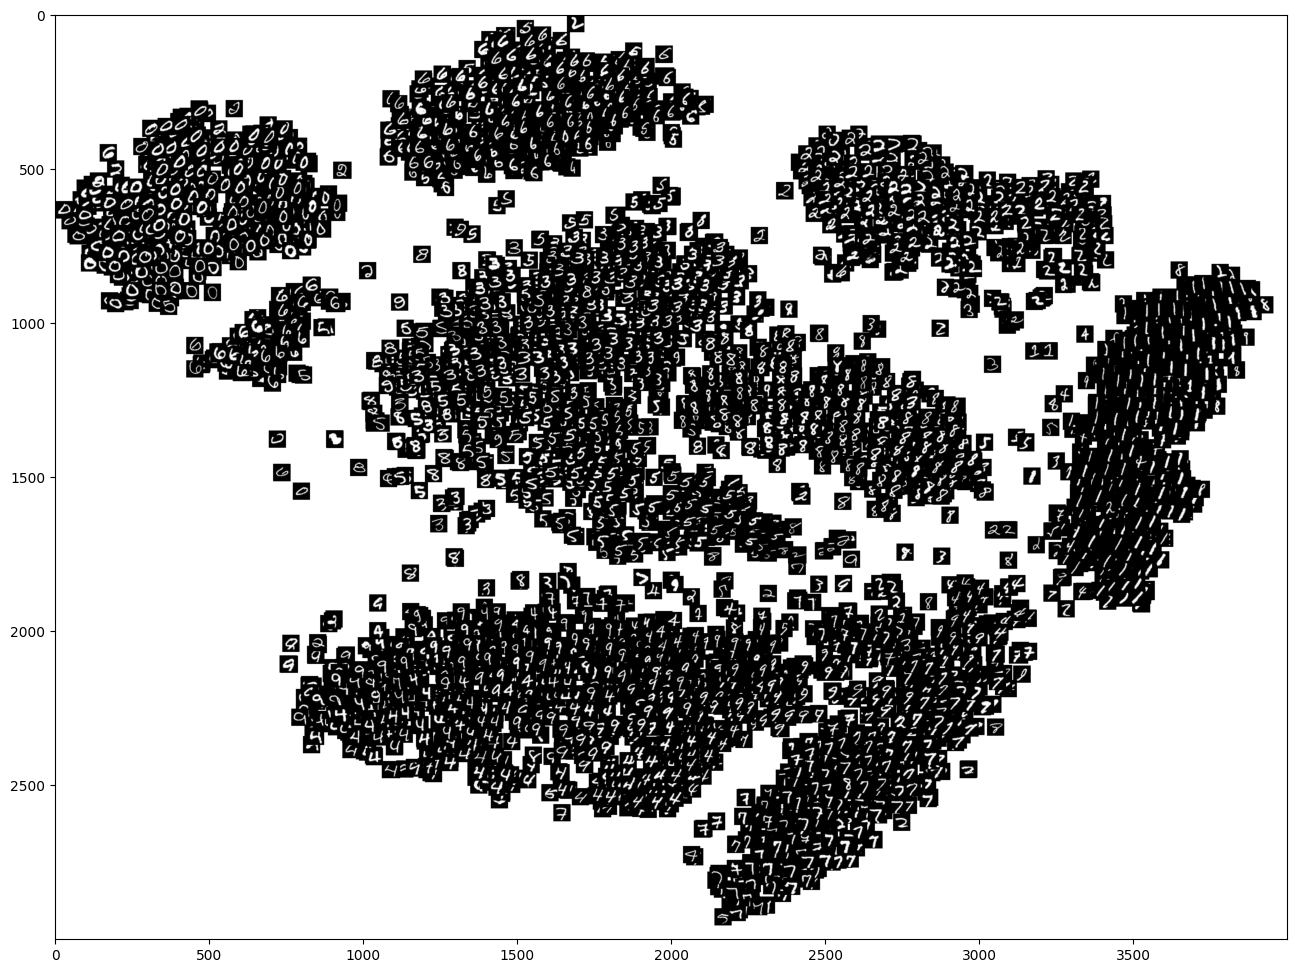

In [13]:
# plt
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))

# for every image
for img, x, y in zip(original_images, tx, ty):
    # open one pic
    tile = PIL.Image.fromarray(np.uint8(img))
    # get the smallest ratio
    rs = max(0.5, tile.width/max_dim, tile.height/max_dim)
    # resize the pic
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    # position the pic in the graph scaling it's coordinates to its x and y of the embedded space
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (16,12))
plt.imshow(full_image)